## Working with text pt.2

I had my first experiment with MultinomialNB and I got a bad accuracy score of .57. It must be said though that I only used 1-grams in my BoW model, so it's this model couldn't get word dependency. Now I'll try with an RNN.

In [1]:
import pandas as pd 
import numpy as np 
import os
import tensorflow as tf
import matplotlib.pyplot as plt 

In [4]:
from sagemaker.session import Session, get_execution_role

sagemaker_session = Session(default_bucket="tinggitecc")
bucket = sagemaker_session.default_bucket()
role = get_execution_role()

'tinggitecc'

In [6]:
df = pd.read_csv(f's3://{bucket}/sagemaker/data/cleaned_data_nostem.csv')

Let's check the content.

In [7]:
df.shape

(44888, 15)

In [8]:
df.head()

,Unnamed: 0,cleanedText,textLength,cleanedTitle,date,subject,class,weekOfYear,dayOfWeek,dayOfYear,quarter,isMonthStart,isMonthEnd,isYearStart,isYearEnd
0,0,washington the united states continue internat...,206.0,epa chief says paris climate agreement,2017-04-02,politics,0,13,6,92,2,False,False,False,False
1,1,president trump tweeted new policy us military...,57.0,breaking president trump announces major polic...,2017-07-26,politics,1,30,2,207,3,False,False,False,False
2,2,washington republican presidential candidate d...,158.0,trump says new hampshire win necessary secure ...,2016-02-07,politics,0,5,6,38,1,False,False,False,False
3,3,moscow the kremlin said thursday confident uni...,44.0,sanctions aimed turning business elite putin,2017-11-30,general,0,48,3,334,4,False,True,False,False
4,4,kellyanne conway response williams criticism c...,8.0,must kellyanne conway punches back after juan ...,2016-12-27,politics,1,52,1,362,4,False,False,False,False


I forgot to drop the index from the dataset, and also I'll be working only with the article text.

In [9]:
df = df[['class','cleanedText']]
df.columns=['targetClass','article']

In [10]:
df.dropna(inplace=True)

Since I want to remove null or very short sequences or too long sequences, I'll build a mask to filter out those kind of sequences.

In [11]:
df['articleLength'] = df['article'].apply(lambda x: len(x.split()))
#df['titleLength']  =df['title'].apply(lambda x: len(x.split()))

In [12]:
filter_by_text_length = (df['articleLength'] > 20) & (df['articleLength'] <=500)

In [13]:
df_filt = df[filter_by_text_length]

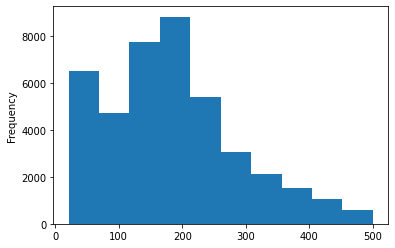

In [14]:
df_filt['articleLength'].plot(kind='hist')

In [15]:
#df_filt['titleLength'].plot(kind='hist')

So, filtering by article length did not have any impact on title length distribution.

In [16]:
df.drop('articleLength',axis=1,inplace=True)

Here I am splitting the data with stratification on the target column, to get training, validation and test datasets.

In [17]:
from sklearn.model_selection import train_test_split

X_train,X_test, y_train,y_test = train_test_split(df_filt.drop('targetClass',axis=1),
                                                 df_filt['targetClass'],
                                                 test_size=0.25,
                                                 stratify=df_filt['targetClass'],
                                                 random_state=1)

X_train,X_val, y_train,y_val = train_test_split(X_train,
                                                 y_train,
                                                 test_size=0.25,
                                                 stratify=y_train,
                                                 random_state=1)



In [18]:
X_train.reset_index(drop=True,inplace=True)
X_val.reset_index(drop=True,inplace=True)
X_test.reset_index(drop=True,inplace=True)
y_train.reset_index(drop=True,inplace=True)
y_val.reset_index(drop=True,inplace=True)
y_test.reset_index(drop=True,inplace=True)

Then, I build a tokenizer and pad sequences to 500 words.

In [19]:
from tensorflow.keras.preprocessing.text import Tokenizer

In [20]:
text_tokenizer = Tokenizer(num_words=80000)
#title_tokenizer = Tokenizer(num_words=1000)

text_tokenizer.fit_on_texts(X_train['article'].astype(str))
#title_tokenizer.fit_on_texts(X_train['title'].astype(str))

In [21]:
from tensorflow.keras.preprocessing import sequence

In [22]:
X_train = text_tokenizer.texts_to_sequences(X_train['article'])
#title_sequences = title_tokenizer.texts_to_sequences(X_train['title'])
X_val = text_tokenizer.texts_to_sequences(X_val['article'])
X_test= text_tokenizer.texts_to_sequences(X_test['article'])

In [23]:
X_train = sequence.pad_sequences(X_train,maxlen=500, padding='post')
X_val = sequence.pad_sequences(X_val,maxlen=500, padding='post')
X_test= sequence.pad_sequences(X_test,maxlen=500, padding='post')

Here, I am concatenating y's and x's to upload data to S3 for training, validation and test.

In [21]:
train_df = pd.concat([y_train,pd.DataFrame(X_train)], axis=1)
val_df = pd.concat([y_val,pd.DataFrame(X_val)], axis=1)
test_df = pd.concat([y_test,pd.DataFrame(X_test)],axis=1)

In [25]:
train_path = 'data/train.csv'
test_path = 'data/test.csv'
val_path = 'data/val.csv'

#train_df.to_csv(train_path,header=False,index=False)
#val_df.to_csv(val_path,header=False,index=False)
#test_df.to_csv(test_path,header=False,index=False)

In [26]:
train_data = sagemaker_session.upload_data(path=train_path, bucket=bucket, key_prefix='sagemaker/data')
val_data = sagemaker_session.upload_data(path=val_path, bucket=bucket, key_prefix='sagemaker/data')
test_data = sagemaker_session.upload_data(path=test_path, bucket=bucket, key_prefix='sagemaker/data')


## Model Training

In [27]:
input_channels = {"train":train_data, "validation":val_data}

In [28]:
from sagemaker.tensorflow import TensorFlow

In [33]:
# create a TensorFlow estimator
estimator = TensorFlow(entry_point='source_train/train_keras_lstm.py',
                       train_instance_type='ml.m4.xlarge',
                       train_instance_count=1,
                       role=role, 
                       framework_version='2.1.0',
                       py_version='py3',
                      hyperparameters={"n_epochs":3})

In [34]:
estimator.fit(input_channels)

'create_image_uri' will be deprecated in favor of 'ImageURIProvider' class in SageMaker Python SDK v2.
's3_input' class will be renamed to 'TrainingInput' in SageMaker Python SDK v2.
's3_input' class will be renamed to 'TrainingInput' in SageMaker Python SDK v2.
'create_image_uri' will be deprecated in favor of 'ImageURIProvider' class in SageMaker Python SDK v2.


2020-08-28 05:46:19 Starting - Starting the training job...
2020-08-28 05:46:21 Starting - Launching requested ML instances......
2020-08-28 05:47:48 Starting - Preparing the instances for training......
2020-08-28 05:48:32 Downloading - Downloading input data...
2020-08-28 05:49:19 Training - Training image download completed. Training in progress...2020-08-28 05:49:23,891 sagemaker-containers INFO     Imported framework sagemaker_tensorflow_container.training
2020-08-28 05:49:23,898 sagemaker-containers INFO     No GPUs detected (normal if no gpus installed)
2020-08-28 05:49:24,241 sagemaker-containers INFO     No GPUs detected (normal if no gpus installed)
2020-08-28 05:49:24,260 sagemaker-containers INFO     No GPUs detected (normal if no gpus installed)
2020-08-28 05:49:24,277 sagemaker-containers INFO     No GPUs detected (normal if no gpus installed)
2020-08-28 05:49:24,290 sagemaker-containers INFO     Invoking user script

Training Env:

{
    "additional_framework_parameters"

#015  256/23408 [..............................] - ETA: 5:14 - loss: 0.0173 - accuracy: 0.9961#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#015  512/23408 [..............................] - ETA: 4:58 - loss: 0.0312 - accuracy: 0.9902#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#015  768/23408 [..............................] - ETA: 4:56 - loss: 0.0219 - accuracy: 0.99

#015  256/23408 [..............................] - ETA: 5:04 - loss: 0.0045 - accuracy: 1.0000#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#015  512/23408 [..............................] - ETA: 4:56 - loss: 0.0041 - accuracy: 1.0000#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#015  768/23408 [..............................] - ETA: 4:50 - loss: 0.0035 - accuracy: 1.00


2020-08-28 06:07:00 Uploading - Uploading generated training model2020-08-28 06:06:50.288856: W tensorflow/python/util/util.cc:319] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.
Instructions for updating:
If using Keras pass *_constraint arguments to layers.
Instructions for updating:
If using Keras pass *_constraint arguments to layers.
INFO:tensorflow:Assets written to: /opt/ml/model/bi_lstm/1/assets
INFO:tensorflow:Assets written to: /opt/ml/model/bi_lstm/1/assets
[2020-08-28 06:06:55.623 ip-10-0-88-41.ap-southeast-1.compute.internal:24 INFO utils.py:25] The end of training job file will not be written for jobs running under SageMaker.
2020-08-28 06:06:56,272 sagemaker-containers INFO     Reporting training SUCCESS

2020-08-28 06:07:23 Completed - Training job completed
Training seconds: 1131
Billable seconds: 1131


After training and validating the model (val_acc 0.986) I can deploy the model and invoke the endpoint with test data.

In [35]:
predictor = estimator.deploy(initial_instance_count=1,
                             instance_type='ml.m4.xlarge')

Parameter image will be renamed to image_uri in SageMaker Python SDK v2.
'create_image_uri' will be deprecated in favor of 'ImageURIProvider' class in SageMaker Python SDK v2.


-------------!

Next:
* Split the test data in chunks 
* Concatenate predictions 
* Apply threshold to output probabilities to get predicted class
* Run accuracy score

In [36]:
splitted = np.array_split(X_test,100)

In [37]:
preds = []

In [38]:
for arr in splitted:

    preds.extend(predictor.predict(arr)['predictions'])

In [39]:
preds_df = pd.DataFrame(preds, columns=['preds'])

In [40]:
def threshold(x):
    if x < 0.5:
        return 0
    else:
        return 1

In [41]:
preds_df['preds']=preds_df['preds'].apply(threshold)

In [42]:
target_preds = pd.concat([y_test,preds_df], axis=1)

In [43]:
from sklearn.metrics import accuracy_score

In [45]:
print(accuracy_score(target_preds['targetClass'],target_preds['preds']))

0.985198000768935


In [47]:
text_tokenizer

Great! My benchmark accuracy was about 90%, as in the paper noted in my Capstone Proposal.

Finally I am storing my fitted Tokenizer as pickled file.

In [46]:
import pickle

with open('tokenizer.pkl','wb') as f:
    
    pickle.dump(text_tokenizer,f)

## Conclusion